## Setting up and running optimization in Jupyter


In [1]:
from geecs_scanner.logging_setup import ensure_logging
import logging

from geecs_scanner.data_acquisition.types import ScanConfig, ScanMode

# from geecs_data_utils.types import ScanConfig, ScanMode
from geecs_scanner.data_acquisition.default_scan_manager import get_default_scan_manager
from geecs_scanner.utils import ApplicationPaths
from pathlib import Path

from geecs_data_utils.scan_data import ScanPaths
from image_analysis.config_loader import set_config_base_dir

ensure_logging(
    level=logging.INFO,  # or INFO
    console=True,
    log_dir=None,  # or a path if you want a file
    max_bytes=10_000_000,
    backup_count=5,
)

set_config_base_dir(ScanPaths.paths_config.image_analysis_configs_path)

logging.getLogger("data_logger").setLevel(logging.WARNING)
logging.getLogger("geecs_scanner").setLevel(logging.INFO)
logging.getLogger("geecs_python_api").setLevel(logging.WARNING)
logging.getLogger("image_analysis").setLevel(logging.WARNING)
logging.getLogger("scan_analysis").setLevel(logging.WARNING)


# load the default experiment configuration for Undulator (shot control, etc.)
manager = get_default_scan_manager("Undulator")
manager.shot_control_variables["Trigger.Source"]["OFF"] = "Single shot"
manager.shot_control_variables["Trigger.Source"]["SCAN"] = "Internal"

app_paths = ApplicationPaths(experiment="Undulator")

# Define path to the optimizer config. See documentation for optimizer config structure
optimizer_config_path = (
    app_paths.exp_optimization_routines / "bax_alignment_example.yaml"
)

23:15:51 INFO numexpr.utils - NumExpr defaulting to 8 threads.
23:15:52 INFO geecs_python_api.controls.interface.geecs_database - database config loaded for loasis@192.168.6.14
C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_6068\792359383.py:12: DeprecationWarning: geecs_scanner.data_acquisition.types.ScanConfig/ScanMode have moved to geecs_data_utils.types; please update your imports.
  from geecs_scanner.data_acquisition.types import ScanConfig, ScanMode
23:15:59 INFO image_analysis.config_loader - Config cache cleared
23:15:59 INFO image_analysis.config_loader - Config base dir set to C:\GEECS\Developers Version\source\GEECS-Plugins-Configs\image_analysis_configs
23:16:00 INFO geecs_scanner.data_acquisition.device_manager - Loaded composite variables from C:\GEECS\Developers Version\source\GEECS-Plugins-Configs\scanner_configs\experiments\Undulator\scan_devices\composite_variables.yaml
23:16:00 INFO geecs_scanner.data_acquisition.action_manager - Successfully loaded master acti

In [2]:
# success = manager.reinitialize(config_path=config_filename)
success = manager.reinitialize()

scan_config = ScanConfig
scan_config.start = 1
scan_config.end = 15
scan_config.step = 1
scan_config.wait_time = 4
scan_config.scan_mode = ScanMode.OPTIMIZATION
scan_config.optimizer_config_path = optimizer_config_path

In [3]:
manager.scan_config = scan_config
manager.start_scan_thread(scan_config)

C:\Users\loasis.LOASIS\AppData\Local\pypoetry\Cache\virtualenvs\geecs-docs-R2O6GHEs-py3.10\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\loasis.LOASIS\AppData\Local\pypoetry\Cache\virtualenvs\geecs-docs-R2O6GHEs-py3.10\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\loasis.LOASIS\AppData\Local\pypoetry\Cache\virtualenvs\geecs-docs-R2O6GHEs-py3.10\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\loasis.LOASIS\AppData\Local\pypoetry\Cache\virtualenvs\geecs-docs-R2O6GHEs-py3.10\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
C:\Users\loasis.LOASIS\AppData\Local\pypoetry\Cache\virtualenvs\

In [4]:
import pickle
import torch

data = pickle.load(open("bax_probe_results_8.pkl", "rb"))
data["solution_center"]

array([1.1975, 0.9225])

In [ ]:
manager.stop_scan()

In [ ]:
data.keys()

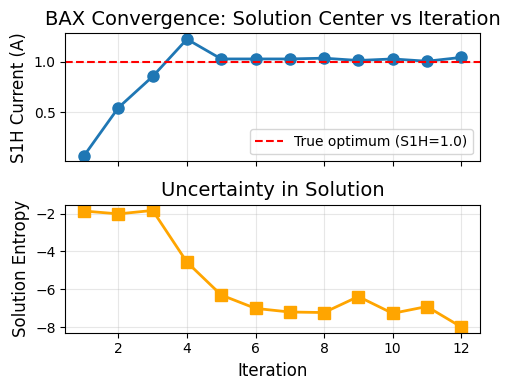

Iteration | S1H Value | Entropy
----------------------------------------
        1 |    0.0750 | -1.8627
        2 |    0.5475 | -2.0142
        3 |    0.8550 | -1.8318
        4 |    1.2225 | -4.5681
        5 |    1.0275 | -6.3074
        6 |    1.0275 | -7.0139
        7 |    1.0275 | -7.2061
        8 |    1.0350 | -7.2338
        9 |    1.0125 | -6.3873
       10 |    1.0275 | -7.2763
       11 |    1.0050 | -6.9157
       12 |    1.0425 | -7.9935

Final S1H: 1.0425 A
True optimum: 1.0000 A
Error: 0.0425 A


In [10]:
import pickle
import matplotlib.pyplot as plt

# Path to scan directory
scan_dir = Path("Z:/data/Undulator/Y2025/10-Oct/25_1028/scans/Scan020")

# Extract solution_center from each iteration
iterations = []
s1h_values = []
emq_values = []
entropies = []

for i in range(1, scan_config.end - 3 + 1):  # Files 1-11
    pkl_file = Path(scan_dir / f"multipoint_bax_alignment_l2_algo_results_{i}.pkl")

    if pkl_file.exists():
        with open(pkl_file, "rb") as f:
            data = pickle.load(f)

        solution = data["solution_center"]
        entropy = data["solution_entropy"]

        iterations.append(i)
        emq_values.append(solution[0])  # EMQ (should be constant ~1.25)
        s1h_values.append(solution[1])  # S1H (the control variable)
        entropies.append(entropy)

# Plot convergence
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), sharex=True)

# S1H convergence
ax1.plot(iterations, s1h_values, "o-", linewidth=2, markersize=8)
ax1.axhline(y=1.0, color="r", linestyle="--", label="True optimum (S1H=1.0)")
ax1.set_ylabel("S1H Current (A)", fontsize=12)
ax1.set_title("BAX Convergence: Solution Center vs Iteration", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Entropy (uncertainty)
ax2.plot(iterations, entropies, "s-", color="orange", linewidth=2, markersize=8)
ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("Solution Entropy", fontsize=12)
ax2.set_title("Uncertainty in Solution", fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("Iteration | S1H Value | Entropy")
print("-" * 40)
for i, s1h, ent in zip(iterations, s1h_values, entropies):
    print(f"{i:9d} | {s1h:9.4f} | {ent:7.4f}")
print(f"\nFinal S1H: {s1h_values[-1]:.4f} A")
print("True optimum: 1.0000 A")
print(f"Error: {abs(s1h_values[-1] - 1.0):.4f} A")

Iter   Sol Ctr    Mean Min   Most Common  VO Range             # Unique  
1         0.0750    0.0750     -0.7500 5.1099-1699.4860        18
2         0.5475    0.5475      1.0500 0.7284-2157.0091        19
3         0.8550    0.8550      1.5000 0.4461-2322.1223        15
4         1.2225    1.2225      1.0500 1.3875-3139.6170        16
5         1.0275    1.0275      1.0500 0.8552-3125.4158        10
6         1.0275    1.0275      1.0500 5.3408-2979.6022         8
7         1.0275    1.0275      1.0500 11.2768-2607.4171         7
8         1.0350    1.0350      1.0500 1.1270-2208.5611         7
9         1.0125    1.0125      1.0500 8.8410-2110.4025         8
10        1.0275    1.0275      1.0500 14.7573-2237.8769         7
11        1.0050    1.0050      1.0500 3.0773-2161.1800         8
12        1.0425    1.0425      1.0500 1.7341-2188.0054         6


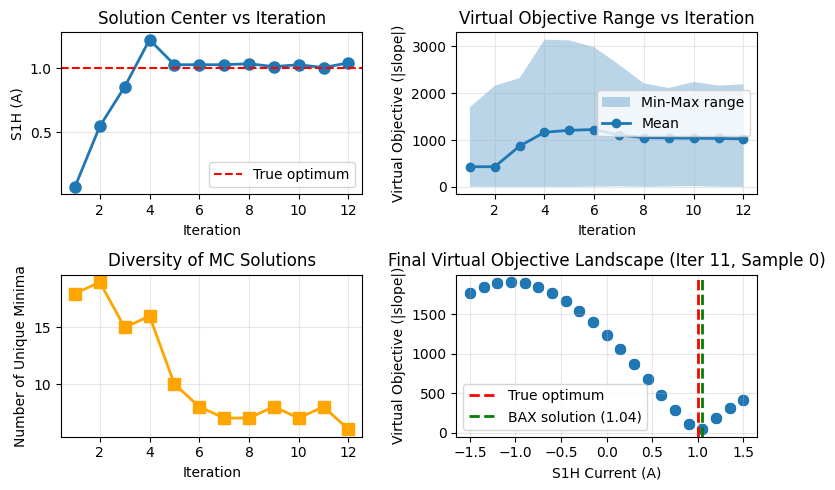


Final result: S1H = 1.0425 A
True optimum: S1H = 1.0000 A
Error: 0.0425 A


In [11]:
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

# Collect data from all iterations
results = []

for sample in range(1, scan_config.end - 2):  # Iterations 1-11
    try:
        file_path = Path(
            scan_dir / f"multipoint_bax_alignment_l2_algo_results_{sample}.pkl"
        )
        data = pickle.load(open(file_path, "rb"))

        test_points = data["test_points"]
        posterior_samples = data["posterior_samples"]
        solution_center = data["solution_center"]

        S, N, _ = posterior_samples.shape

        # Get minimum location for each MC sample
        min_indices = posterior_samples.argmin(dim=1).squeeze()
        min_s1h_values = test_points[min_indices, 1]  # S1H values at minima

        # Statistics
        results.append(
            {
                "iteration": sample,
                "solution_center_s1h": solution_center[1],  # S1H from solution_center
                "vo_min": float(posterior_samples.min()),
                "vo_max": float(posterior_samples.max()),
                "vo_mean": float(posterior_samples.mean()),
                "vo_std": float(posterior_samples.std()),
                "n_unique_minima": len(torch.unique(min_indices)),
                "mean_min_s1h": float(min_s1h_values.mean()),
                "std_min_s1h": float(min_s1h_values.std()),
                "most_common_s1h": float(
                    test_points[torch.mode(min_indices).values, 1]
                ),
            }
        )
    except FileNotFoundError:
        print(f"{file_path} not found")

# Print summary table
print("=" * 100)
print(
    f"{'Iter':<6} {'Sol Ctr':<10} {'Mean Min':<10} {'Most Common':<12} {'VO Range':<20} {'# Unique':<10}"
)
print("=" * 100)
for r in results:
    print(
        f"{r['iteration']:<6} "
        f"{r['solution_center_s1h']:>9.4f} "
        f"{r['mean_min_s1h']:>9.4f} "
        f"{r['most_common_s1h']:>11.4f} "
        f"{r['vo_min']:.4f}-{r['vo_max']:.4f} "
        f"{r['n_unique_minima']:>9}"
    )
print("=" * 100)

# Create comprehensive plot
fig, axes = plt.subplots(2, 2, figsize=(8.0, 5))

# Plot 1: Solution center convergence
ax = axes[0, 0]
iters = [r["iteration"] for r in results]
sol_centers = [r["solution_center_s1h"] for r in results]
ax.plot(iters, sol_centers, "o-", linewidth=2, markersize=8)
ax.axhline(y=1.0, color="r", linestyle="--", label="True optimum")
ax.set_xlabel("Iteration")
ax.set_ylabel("S1H (A)")
ax.set_title("Solution Center vs Iteration")
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Virtual objective range evolution
ax = axes[0, 1]
vo_mins = [r["vo_min"] for r in results]
vo_maxs = [r["vo_max"] for r in results]
vo_means = [r["vo_mean"] for r in results]
ax.fill_between(iters, vo_mins, vo_maxs, alpha=0.3, label="Min-Max range")
ax.plot(iters, vo_means, "o-", linewidth=2, markersize=6, label="Mean")
ax.set_xlabel("Iteration")
ax.set_ylabel("Virtual Objective (|slope|)")
ax.set_title("Virtual Objective Range vs Iteration")
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Number of unique minima
ax = axes[1, 0]
n_unique = [r["n_unique_minima"] for r in results]
ax.plot(iters, n_unique, "s-", linewidth=2, markersize=8, color="orange")
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of Unique Minima")
ax.set_title("Diversity of MC Solutions")
ax.grid(True, alpha=0.3)

# Plot 4: Final iteration virtual objective landscape
ax = axes[1, 1]
final_data = pickle.load(open(file_path, "rb"))
s1h_vals = final_data["test_points"][:, 1].numpy()
vo_vals = final_data["posterior_samples"][0, :, 0].numpy()
ax.scatter(s1h_vals, vo_vals, alpha=0.6, s=50)
ax.axvline(x=1.0, color="r", linestyle="--", linewidth=2, label="True optimum")
ax.axvline(
    x=results[-1]["solution_center_s1h"],
    color="g",
    linestyle="--",
    linewidth=2,
    label=f"BAX solution ({results[-1]['solution_center_s1h']:.2f})",
)
ax.set_xlabel("S1H Current (A)")
ax.set_ylabel("Virtual Objective (|slope|)")
ax.set_title("Final Virtual Objective Landscape (Iter 11, Sample 0)")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("bax_convergence_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nFinal result: S1H = {results[-1]['solution_center_s1h']:.4f} A")
print("True optimum: S1H = 1.0000 A")
print(f"Error: {abs(results[-1]['solution_center_s1h'] - 1.0):.4f} A")

In [12]:
from xopt.generators.bayesian.visualize import visualize_model

model = manager.optimizer.xopt.generator.model
vocs2 = manager.optimizer.xopt.vocs
data2 = manager.optimizer.xopt.data

In [ ]:
%matplotlib inline
fig, ax = visualize_model(
    model,
    vocs2,
    data2,
    variable_names=[
        "U_EMQTripletBipolar:Current_Limit.Ch1",
        "U_S1H:Current",
    ],
    reference_point={"U_S1V:Current": 1.0},
    show_prior_mean=False,
    n_grid=50,
)